# Trading Strategies powered by Machine Learning - Random Forest Classifier

## Random Forest Classifier with scikit-learn 

In [1]:
import sys
sys.path.append('../../')

In [2]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv

In [3]:
from backtesting import Strategy
from sklearn.ensemble import RandomForestClassifier

## Getting the Data

In [4]:
XAUUSD = load_data()

In [5]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [6]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


## ML

### Class and Strategy ML

In [7]:
class Random_Forest_Classifier(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position:
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)

        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

In [8]:
strategy = Random_Forest_Classifier
account_size = 1000
folder_ML_Strategy = 'Random Forest Classifier'

In [9]:
from backtesting import Backtest
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from util.Save_result_return import save_to_csv
import sys
sys.path.append('../../')


plt.style.use("seaborn-v0_8")


class ML_Random_Forest():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None

    def get_rsi(self, df, rsi_period):
        chg = df['Close'].diff(1)
        gain = chg.mask(chg < 0, 0)
        loss = chg.mask(chg > 0, 0)
        avg_gain = gain.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
        avg_loss = loss.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
        rs = abs(avg_gain/avg_loss)
        rsi = 100 - (100/(1+rs))
        return rsi

    def Create_Features(self):

        df = self.data.copy()

        # relative strength index
        df['rsi14'] = self.get_rsi(df, 14)
        # moving averages
        df['sma9'] = df['Close'].rolling(9).mean()
        df['sma180'] = df['Close'].rolling(180).mean()
        df['sma9_var'] = (df['Close']/df['sma9'])-1
        df['sma180_var'] = (df['Close']/df['sma180'])-1

        self.data = df

    def Add_Signal(self):

        df = self.data.copy()
        df["returns"] = np.log(df['Close'].div(df['Close'].shift(1)))
        df['signal_t1'] = np.sign(df.returns)
        df['signal'] = df.signal_t1.shift(-1)
        df = df.drop(columns=['returns', 'signal_t1'])
        df = df.dropna()

        self.data = df

    def Train_Model(self):
        self.Create_Features()
        self.Add_Signal()

        # Extract data within the specified date range
        self.data_train = self.data.loc[self.start_train:self.end_train].copy()
        self.data_test = self.data.loc[self.start_test:self.end_test].copy()

        # Drop missing values from the training dataset
        self.data_train.dropna(inplace=True)

        y_train = self.data_train['signal'].copy()
        x_train = self.data_train.drop(columns=['signal'])
        x_test = self.data_test.drop(columns=['signal'])

        self.model = RandomForestClassifier()
        self.model.fit(x_train, y_train)

        # Make predictions
        self.data_train['pred'] = self.model.predict(x_train)
       
        self.data_test['pred'] = self.model.predict(x_test)
        

    def Backtest(self, data, account_size=1000):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=account_size, margin=1 / 100)
        result = backtest.run()
        return result

    def Run(self):

        self.Train_Model()

        result_train = self.Backtest(self.data_train)

        result_test = self.Backtest(self.data_test)

        return result_train, result_test

In [10]:
ML_Class = ML_Random_Forest

## TF D1

In [11]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'D1'

In [12]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [13]:
train, test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_17120\2282324026.py:89: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_17120\2282324026.py:89: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [14]:
train

Start                     2007-07-29 00:00:00
End                       2019-12-31 00:00:00
Duration                   4538 days 00:00:00
Exposure Time [%]                    99.94836
Equity Final [$]                    32235.887
Equity Peak [$]                     32235.894
Return [%]                          3123.5887
Buy & Hold Return [%]              129.613646
Return (Ann.) [%]                    25.35492
Volatility (Ann.) [%]                3.528186
Sharpe Ratio                         7.186389
Sortino Ratio                      248.275585
Calmar Ratio                        82.516459
Max. Drawdown [%]                   -0.307271
Avg. Drawdown [%]                   -0.017531
Max. Drawdown Duration        5 days 00:00:00
Avg. Drawdown Duration        4 days 00:00:00
# Trades                                 1992
Win Rate [%]                        97.941767
Best Trade [%]                      15.845498
Worst Trade [%]                      -0.77578
Avg. Trade [%]                    

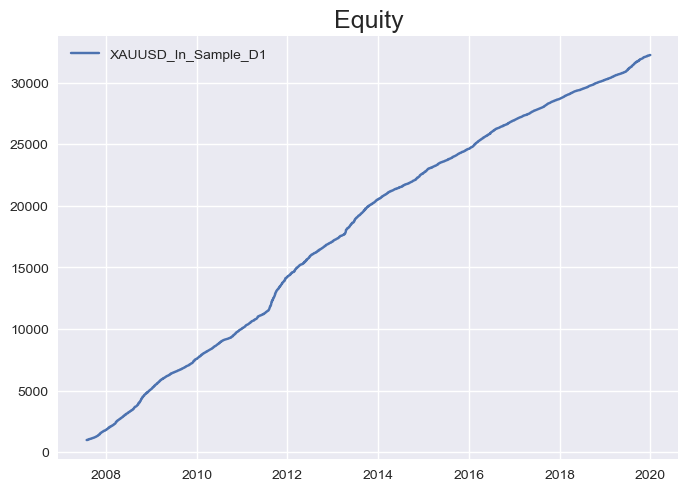

In [15]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [16]:
test

Start                     2020-01-01 00:00:00
End                       2023-03-09 00:00:00
Duration                   1163 days 00:00:00
Exposure Time [%]                    99.79798
Equity Final [$]                     2164.051
Equity Peak [$]                      2243.908
Return [%]                           116.4051
Buy & Hold Return [%]               20.623928
Return (Ann.) [%]                   21.714079
Volatility (Ann.) [%]               23.578824
Sharpe Ratio                         0.920914
Sortino Ratio                        1.816518
Calmar Ratio                         0.879282
Max. Drawdown [%]                  -24.695245
Avg. Drawdown [%]                   -2.979307
Max. Drawdown Duration      255 days 00:00:00
Avg. Drawdown Duration       23 days 00:00:00
# Trades                                  158
Win Rate [%]                        63.924051
Best Trade [%]                      10.098384
Worst Trade [%]                     -7.778138
Avg. Trade [%]                    

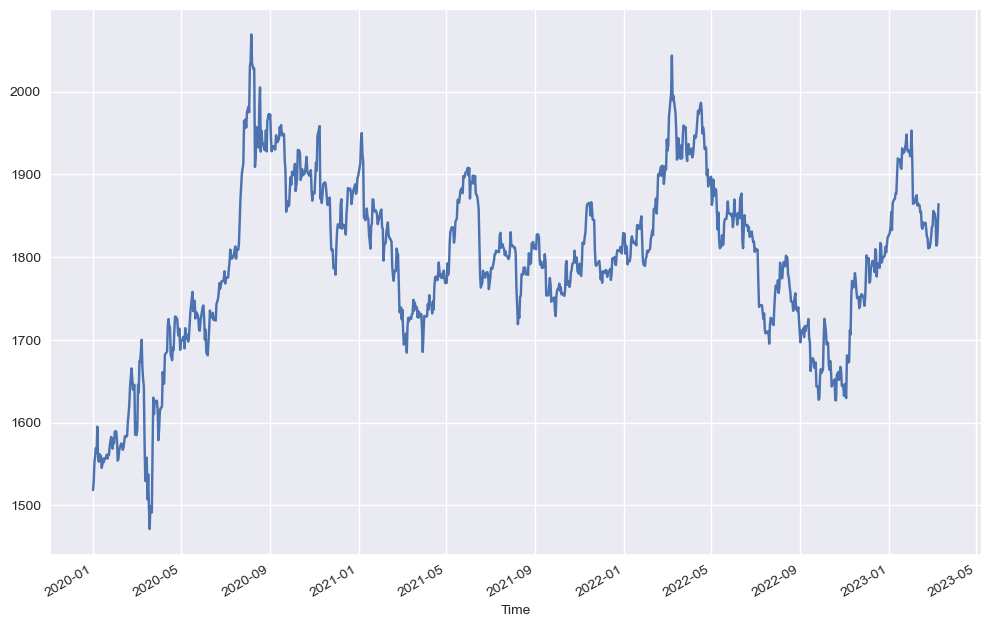

In [17]:
XAUUSD['D1']['Close'].loc['2020':'2023'].plot(figsize=(12, 8))
plt.show()

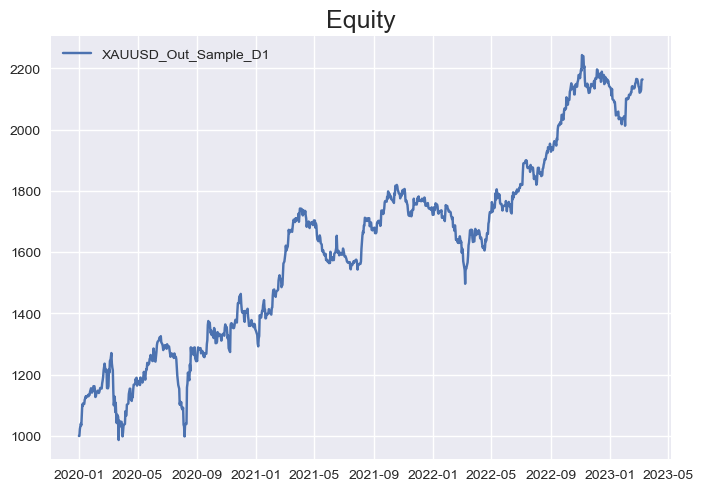

In [18]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

In [19]:
test['_trades'].tail(100)

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
58,1,392,396,1743.155,1741.618,-1.537,-0.000882,2021-04-07,2021-04-12,5 days
59,-1,396,398,1741.618,1746.545,-4.927,-0.002829,2021-04-12,2021-04-14,2 days
60,1,398,399,1746.545,1736.558,-9.987,-0.005718,2021-04-14,2021-04-15,1 days
61,-1,399,400,1736.558,1763.855,-27.297,-0.015719,2021-04-15,2021-04-16,1 days
62,1,400,402,1763.855,1776.675,12.820,0.007268,2021-04-16,2021-04-19,3 days
...,...,...,...,...,...,...,...,...,...,...
153,-1,962,963,1865.405,1868.465,-3.060,-0.001640,2023-02-06,2023-02-07,1 days
154,1,963,964,1868.465,1872.855,4.390,0.002350,2023-02-07,2023-02-08,1 days
155,-1,964,988,1872.855,1813.855,59.000,0.031503,2023-02-08,2023-03-08,28 days
156,1,988,989,1813.855,1815.195,1.340,0.000739,2023-03-08,2023-03-09,1 days


### Save result 

In [20]:
filename_train = f'result_{TF}_In_Sample.csv'

In [21]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [22]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [23]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H4

In [24]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H4'

In [25]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [26]:
train, test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_17120\2282324026.py:89: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_17120\2282324026.py:89: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [27]:
train

Start                     2007-02-09 00:00:00
End                       2019-12-31 20:00:00
Duration                   4708 days 20:00:00
Exposure Time [%]                   99.990334
Equity Final [$]                    68056.615
Equity Peak [$]                     68059.401
Return [%]                          6705.6615
Buy & Hold Return [%]              130.272775
Return (Ann.) [%]                   30.228282
Volatility (Ann.) [%]                3.770003
Sharpe Ratio                         8.018105
Sortino Ratio                      609.932901
Calmar Ratio                       205.459847
Max. Drawdown [%]                   -0.147125
Avg. Drawdown [%]                   -0.008342
Max. Drawdown Duration        4 days 04:00:00
Avg. Drawdown Duration        1 days 06:00:00
# Trades                                10657
Win Rate [%]                        98.348503
Best Trade [%]                      11.391034
Worst Trade [%]                     -0.761831
Avg. Trade [%]                    

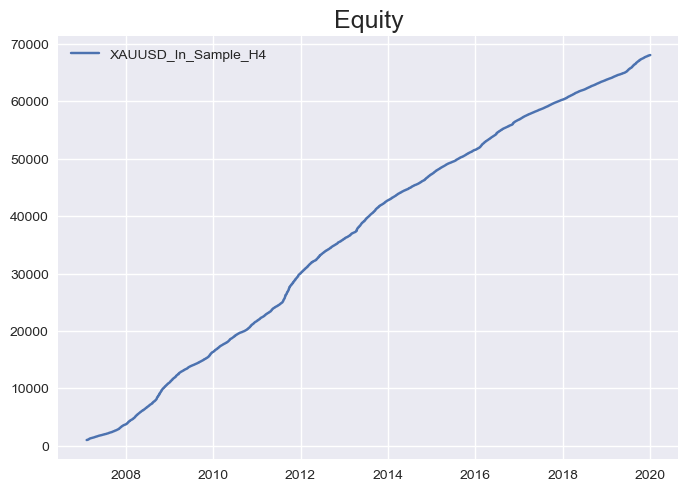

In [28]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [29]:
test

Start                     2020-01-01 20:00:00
End                       2023-03-10 12:00:00
Duration                   1163 days 16:00:00
Exposure Time [%]                   99.960815
Equity Final [$]                      817.358
Equity Peak [$]                      1120.606
Return [%]                           -18.2642
Buy & Hold Return [%]               22.702589
Return (Ann.) [%]                   -4.999159
Volatility (Ann.) [%]               39.026175
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -63.084926
Avg. Drawdown [%]                   -7.279952
Max. Drawdown Duration      966 days 00:00:00
Avg. Drawdown Duration       68 days 07:00:00
# Trades                                  976
Win Rate [%]                        51.331967
Best Trade [%]                       6.433576
Worst Trade [%]                     -9.285356
Avg. Trade [%]                    

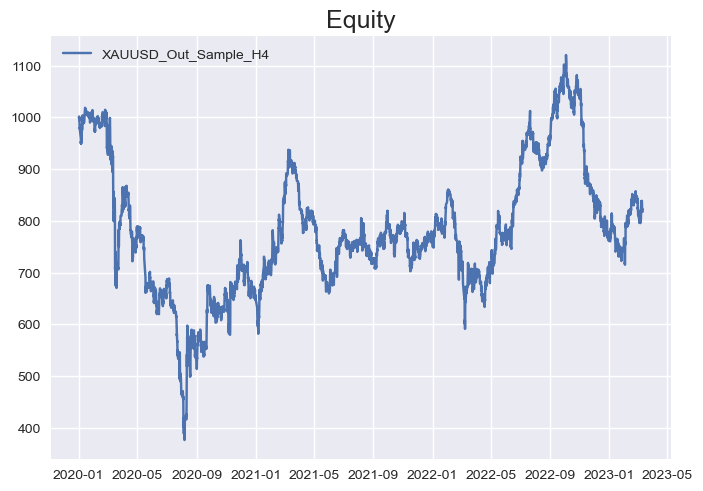

In [30]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [31]:
filename_train = f'result_{TF}_In_Sample.csv'

In [32]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [33]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [34]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H1

In [35]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H1'

In [36]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [37]:
train, test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_17120\2282324026.py:89: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_17120\2282324026.py:89: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [38]:
train

Start                     2007-01-10 11:00:00
End                       2019-12-31 21:00:00
Duration                   4738 days 10:00:00
Exposure Time [%]                   99.997466
Equity Final [$]                   129430.206
Equity Peak [$]                    129430.989
Return [%]                         12843.0206
Buy & Hold Return [%]              148.232655
Return (Ann.) [%]                   35.259141
Volatility (Ann.) [%]                4.928573
Sharpe Ratio                         7.154027
Sortino Ratio                      969.540892
Calmar Ratio                       230.802445
Max. Drawdown [%]                   -0.152768
Avg. Drawdown [%]                   -0.005028
Max. Drawdown Duration        3 days 14:00:00
Avg. Drawdown Duration        0 days 09:00:00
# Trades                                41491
Win Rate [%]                        97.481382
Best Trade [%]                      10.936788
Worst Trade [%]                     -0.930384
Avg. Trade [%]                    

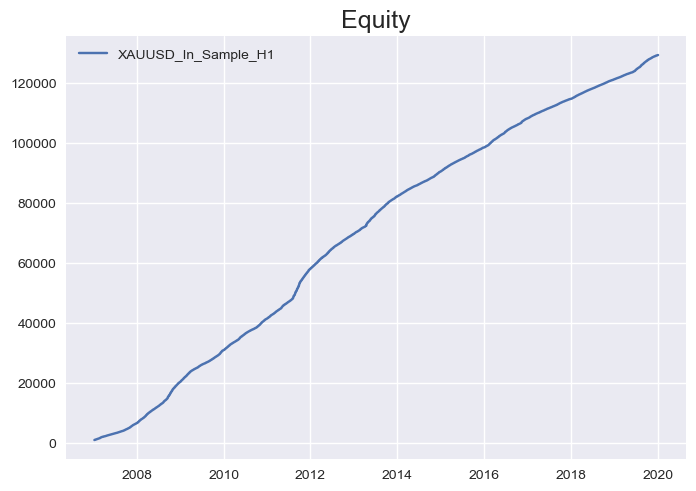

In [39]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [40]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 16:00:00
Duration                   1163 days 17:00:00
Exposure Time [%]                   99.989397
Equity Final [$]                      1363.17
Equity Peak [$]                      1544.013
Return [%]                             36.317
Buy & Hold Return [%]               22.191486
Return (Ann.) [%]                     8.19683
Volatility (Ann.) [%]               28.793377
Sharpe Ratio                         0.284678
Sortino Ratio                        0.459038
Calmar Ratio                         0.231395
Max. Drawdown [%]                  -35.423565
Avg. Drawdown [%]                   -1.906785
Max. Drawdown Duration      352 days 09:00:00
Avg. Drawdown Duration       11 days 03:00:00
# Trades                                 4423
Win Rate [%]                        54.894868
Best Trade [%]                        3.38475
Worst Trade [%]                     -6.067329
Avg. Trade [%]                    

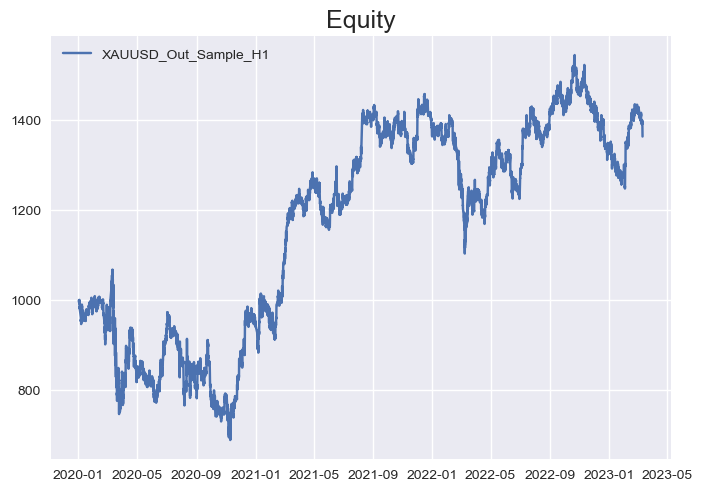

In [41]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [42]:
filename_train = f'result_{TF}_In_Sample.csv'

In [43]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [44]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [45]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M30

In [46]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M30'

In [47]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [48]:
train, test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_17120\2282324026.py:89: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_17120\2282324026.py:89: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [49]:
train

Start                     2007-01-04 17:30:00
End                       2019-12-31 21:30:00
Duration                   4744 days 04:00:00
Exposure Time [%]                   99.998729
Equity Final [$]                   181313.988
Equity Peak [$]                    181314.708
Return [%]                         18031.3988
Buy & Hold Return [%]              142.517818
Return (Ann.) [%]                    38.17467
Volatility (Ann.) [%]                5.954753
Sharpe Ratio                          6.41079
Sortino Ratio                     4519.350095
Calmar Ratio                       180.935139
Max. Drawdown [%]                   -0.210985
Avg. Drawdown [%]                   -0.004649
Max. Drawdown Duration        3 days 09:30:00
Avg. Drawdown Duration        0 days 04:32:00
# Trades                                82579
Win Rate [%]                        97.294712
Best Trade [%]                       8.111091
Worst Trade [%]                     -0.961891
Avg. Trade [%]                    

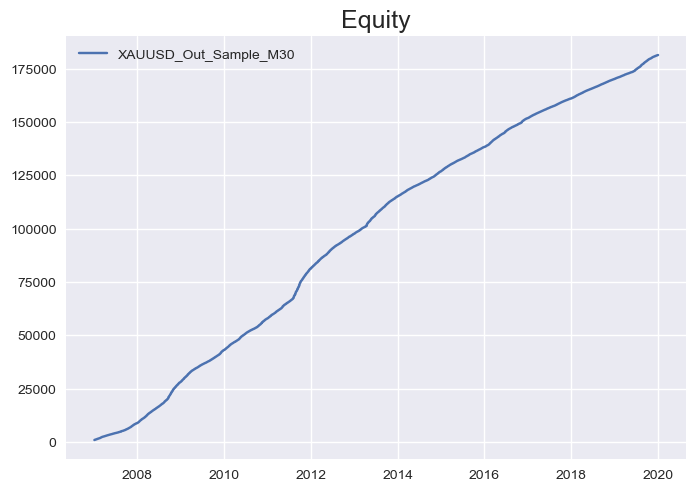

In [50]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [51]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 18:00:00
Exposure Time [%]                   99.994697
Equity Final [$]                     1118.738
Equity Peak [$]                      1450.839
Return [%]                            11.8738
Buy & Hold Return [%]               22.568469
Return (Ann.) [%]                    2.894242
Volatility (Ann.) [%]               31.150823
Sharpe Ratio                         0.092911
Sortino Ratio                        0.141235
Calmar Ratio                         0.066755
Max. Drawdown [%]                  -43.356067
Avg. Drawdown [%]                   -1.614355
Max. Drawdown Duration      442 days 06:00:00
Avg. Drawdown Duration        9 days 09:42:00
# Trades                                10635
Win Rate [%]                        53.841091
Best Trade [%]                       3.444782
Worst Trade [%]                      -5.20931
Avg. Trade [%]                    

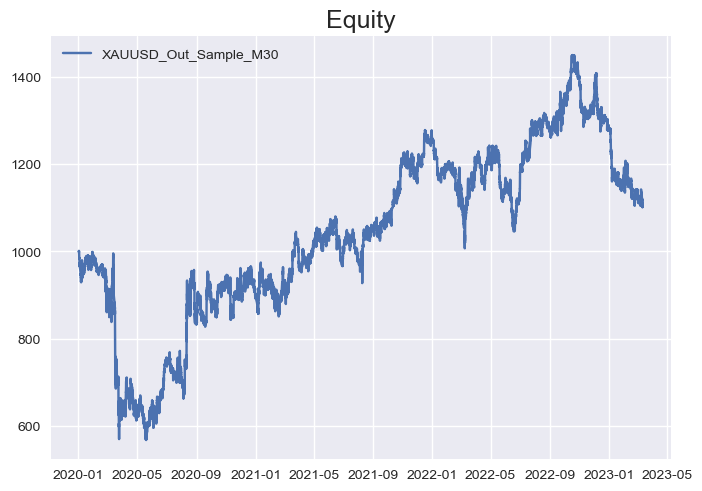

In [52]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [53]:
filename_train = f'result_{TF}_In_Sample.csv'

In [54]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [55]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [56]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M15

In [57]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M15'

In [58]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [59]:
train, test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_17120\2282324026.py:89: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_17120\2282324026.py:89: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [60]:
train

Start                     2014-09-25 11:15:00
End                       2019-12-31 21:45:00
Duration                   1923 days 10:30:00
Exposure Time [%]                   99.998392
Equity Final [$]                    82648.802
Equity Peak [$]                     82649.252
Return [%]                          8164.8802
Buy & Hold Return [%]               25.344676
Return (Ann.) [%]                   95.860792
Volatility (Ann.) [%]               18.244342
Sharpe Ratio                         5.254275
Sortino Ratio                      3543.11209
Calmar Ratio                       182.944797
Max. Drawdown [%]                   -0.523988
Avg. Drawdown [%]                   -0.001708
Max. Drawdown Duration        3 days 06:15:00
Avg. Drawdown Duration        0 days 03:58:00
# Trades                                64702
Win Rate [%]                        98.641464
Best Trade [%]                       3.051941
Worst Trade [%]                     -1.220078
Avg. Trade [%]                    

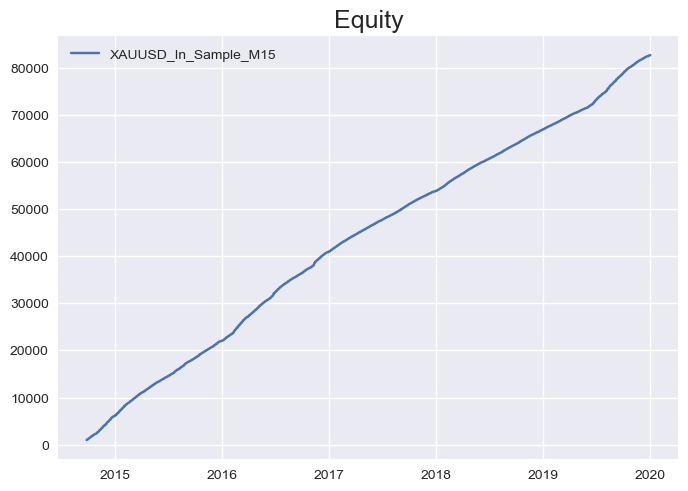

In [61]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [62]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:30:00
Duration                   1163 days 18:30:00
Exposure Time [%]                   99.997348
Equity Final [$]                     1322.814
Equity Peak [$]                      1536.793
Return [%]                            32.2814
Buy & Hold Return [%]               22.665911
Return (Ann.) [%]                    7.408771
Volatility (Ann.) [%]               24.133817
Sharpe Ratio                         0.306987
Sortino Ratio                        0.503761
Calmar Ratio                         0.210359
Max. Drawdown [%]                  -35.219703
Avg. Drawdown [%]                   -1.416675
Max. Drawdown Duration      337 days 00:30:00
Avg. Drawdown Duration        6 days 02:48:00
# Trades                                14114
Win Rate [%]                        57.949554
Best Trade [%]                       2.259751
Worst Trade [%]                     -3.930421
Avg. Trade [%]                    

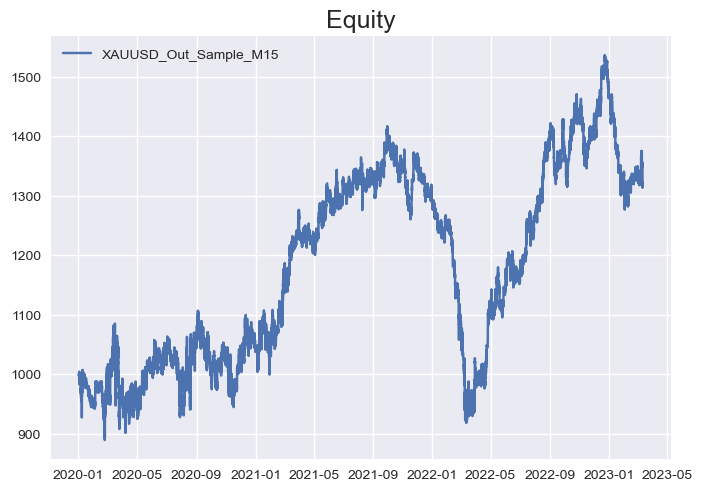

In [63]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [64]:
filename_train = f'result_{TF}_In_Sample.csv'

In [65]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [66]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [67]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M5

In [68]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M5'

In [69]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [70]:
train, test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_17120\2282324026.py:89: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
C:\Users\Win10\AppData\Local\Temp\ipykernel_17120\2282324026.py:89: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [71]:
train

Start                     2020-05-18 03:05:00
End                       2022-12-30 21:55:00
Duration                    956 days 18:50:00
Exposure Time [%]                   99.998927
Equity Final [$]                   129793.178
Equity Peak [$]                    129793.763
Return [%]                         12879.3178
Buy & Hold Return [%]                3.547724
Return (Ann.) [%]                  324.554848
Volatility (Ann.) [%]               89.114193
Sharpe Ratio                         3.642011
Sortino Ratio                     3911.806575
Calmar Ratio                       783.557854
Max. Drawdown [%]                   -0.414207
Avg. Drawdown [%]                   -0.000865
Max. Drawdown Duration        3 days 04:30:00
Avg. Drawdown Duration        0 days 01:11:00
# Trades                                95677
Win Rate [%]                         98.77609
Best Trade [%]                       2.888443
Worst Trade [%]                     -0.876337
Avg. Trade [%]                    

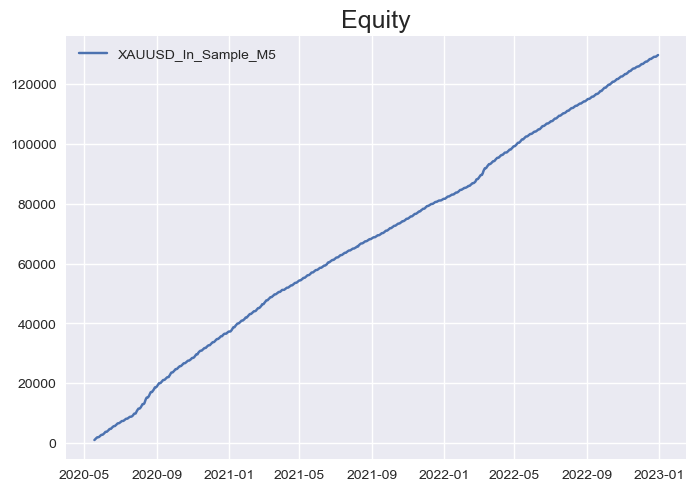

In [72]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [73]:
test

Start                     2023-01-02 23:00:00
End                       2023-03-10 17:50:00
Duration                     66 days 18:50:00
Exposure Time [%]                   99.985069
Equity Final [$]                     1131.788
Equity Peak [$]                       1136.91
Return [%]                            13.1788
Buy & Hold Return [%]                 2.07534
Return (Ann.) [%]                   66.172389
Volatility (Ann.) [%]               45.416297
Sharpe Ratio                         1.457019
Sortino Ratio                        3.720431
Calmar Ratio                          5.06684
Max. Drawdown [%]                  -13.059894
Avg. Drawdown [%]                   -0.535999
Max. Drawdown Duration       27 days 23:15:00
Avg. Drawdown Duration        0 days 16:36:00
# Trades                                 5248
Win Rate [%]                        52.286585
Best Trade [%]                       1.586175
Worst Trade [%]                     -1.124454
Avg. Trade [%]                    

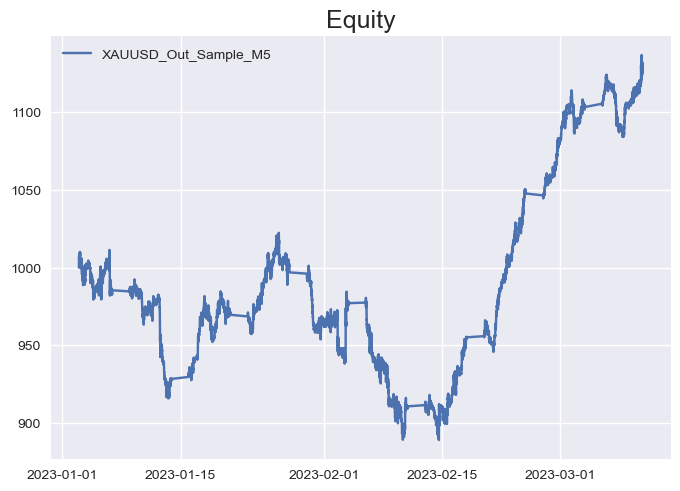

In [74]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [75]:
filename_train = f'result_{TF}_In_Sample.csv'

In [76]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [77]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [78]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M1

In [79]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M1'

In [80]:
ml = ML_Class(data, strategy, start_train, start_test, end_train, end_test, TF)

In [81]:
train, test = ml.Run()

C:\Users\Win10\AppData\Local\Temp\ipykernel_17120\2282324026.py:89: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,
c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_stats.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
C:\Users\Win10\AppData\Local\Temp\ipykernel_17120\2282324026.py:89: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  backtest = Backtest(data, self.strategy,


### In-Sample Backtesting

In [82]:
train

Start                     2022-08-17 02:12:00
End                       2022-12-30 21:58:00
Duration                    135 days 19:46:00
Exposure Time [%]                   99.998495
Equity Final [$]                     37747.82
Equity Peak [$]                     37748.243
Return [%]                           3674.782
Buy & Hold Return [%]                2.673738
Return (Ann.) [%]                 146483.8399
Volatility (Ann.) [%]            94245.399229
Sharpe Ratio                         1.554281
Sortino Ratio                             inf
Calmar Ratio                   3810035.780025
Max. Drawdown [%]                   -0.038447
Avg. Drawdown [%]                   -0.000604
Max. Drawdown Duration        3 days 01:08:00
Avg. Drawdown Duration        0 days 00:11:00
# Trades                                65773
Win Rate [%]                        96.702294
Best Trade [%]                        1.29732
Worst Trade [%]                     -0.378417
Avg. Trade [%]                    

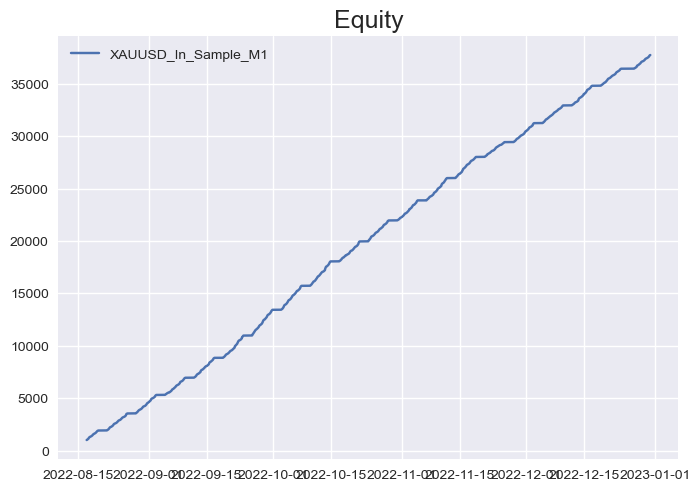

In [83]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [84]:
test

Start                     2023-01-02 23:00:00
End                       2023-03-10 17:58:00
Duration                     66 days 18:58:00
Exposure Time [%]                   99.997013
Equity Final [$]                     1162.531
Equity Peak [$]                      1202.409
Return [%]                            16.2531
Buy & Hold Return [%]                2.050654
Return (Ann.) [%]                   92.469847
Volatility (Ann.) [%]               46.682126
Sharpe Ratio                         1.980841
Sortino Ratio                        7.100886
Calmar Ratio                        10.178782
Max. Drawdown [%]                   -9.084569
Avg. Drawdown [%]                   -0.240446
Max. Drawdown Duration       28 days 22:44:00
Avg. Drawdown Duration        0 days 05:31:00
# Trades                                 4557
Win Rate [%]                        61.860873
Best Trade [%]                       1.343054
Worst Trade [%]                     -1.525968
Avg. Trade [%]                    

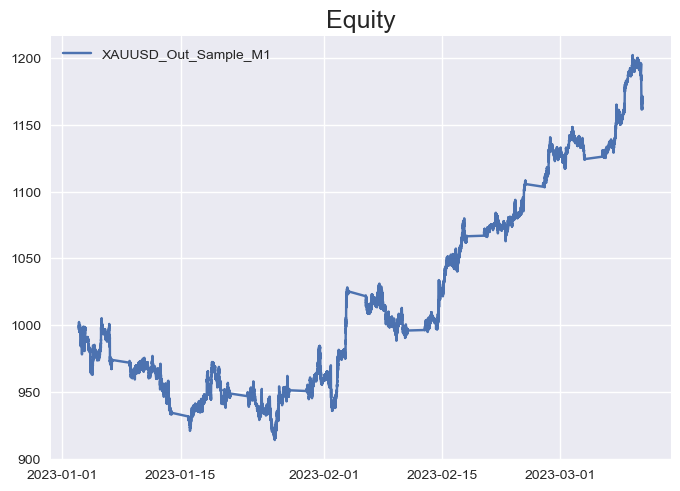

In [85]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [86]:
filename_train = f'result_{TF}_In_Sample.csv'

In [87]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')